# Movie Recommendations System

## Imports

In [473]:
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import seaborn as sns
import numpy as np
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import TruncatedSVD, NMF
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import mean_squared_error

<span style="color: red; font-size: 30px">Change **viewPlots** below if you want to run plots!!</span>

In [2]:
viewPlots = True

## EDA

In [3]:
movies_df = pd.read_csv("movies.csv")
movies_df

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy
...,...,...,...
9737,193581,Black Butler: Book of the Atlantic (2017),Action|Animation|Comedy|Fantasy
9738,193583,No Game No Life: Zero (2017),Animation|Comedy|Fantasy
9739,193585,Flint (2017),Drama
9740,193587,Bungo Stray Dogs: Dead Apple (2018),Action|Animation


In [4]:
ratings_df = pd.read_csv("ratings.csv")
ratings_df

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931
...,...,...,...,...
100831,610,166534,4.0,1493848402
100832,610,168248,5.0,1493850091
100833,610,168250,5.0,1494273047
100834,610,168252,5.0,1493846352


In [5]:
movies_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  9742 non-null   int64 
 1   title    9742 non-null   object
 2   genres   9742 non-null   object
dtypes: int64(1), object(2)
memory usage: 228.5+ KB


In [6]:
movies_df.describe()

,movieId
count,9742.000000
mean,42200.353623
std,52160.494854
min,1.000000
25%,3248.250000
50%,7300.000000
75%,76232.000000
max,193609.000000


#### Recommendation: Movie Data 
Movie DF mostly categorical data that can be encoded later. Need to create a genre table with a separator. Why is there a big jump or gap in movieId? very weird
- Join with ratings table on movieId for a playground df
- Genre needs to be encoded as well with a separator of "|"
- No missing data
- movieID needs a closer look, has a high std and big gap between 50% to 75%

In [7]:
ratings_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100836 non-null  int64  
 1   movieId    100836 non-null  int64  
 2   rating     100836 non-null  float64
 3   timestamp  100836 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB


In [8]:
ratings_df.describe()

,userId,movieId,rating,timestamp
count,100836.000000,100836.000000,100836.000000,1.008360e+05
mean,326.127564,19435.295718,3.501557,1.205946e+09
std,182.618491,35530.987199,1.042529,2.162610e+08
min,1.000000,1.000000,0.500000,8.281246e+08
25%,177.000000,1199.000000,3.000000,1.019124e+09
50%,325.000000,2991.000000,3.500000,1.186087e+09
75%,477.000000,8122.000000,4.000000,1.435994e+09
max,610.000000,193609.000000,5.000000,1.537799e+09


#### Recommendation: Ratings Data
Looks like the rating is a 0-5 rating system, but something is going on with timestamp, looks like it's written as a counter in seconds? Question is what is the starting date this derives from and convert it.
- 0-5 Rating system
- Explore where timestamp derives from -> convert to datetime
- No missing data

### Sample Data 

In [9]:
ratings_df.sample(20)

,userId,movieId,rating,timestamp
31606,219,1005,1.5,1198782801
46713,306,152081,4.0,1518380219
55971,369,6874,3.5,1237082753
18158,115,296,5.0,944954937
71547,462,21,4.0,1121923492
91125,590,7980,4.0,1264910957
37576,254,592,2.5,1180446258
80332,507,150,3.0,838964550
617,6,146,4.0,845555607
68314,441,98809,3.5,1451166520


In [10]:
movies_df.sample(20)

,movieId,title,genres
3059,4103,Empire of the Sun (1987),Action|Adventure|Drama|War
7431,80858,You Again (2010),Comedy
6975,66427,My Name Is Bruce (2007),Comedy|Horror
5372,8958,Ray (2004),Drama
4286,6264,"Core, The (2003)",Action|Drama|Sci-Fi|Thriller
6073,41285,Match Point (2005),Crime|Drama|Romance
3530,4825,"Swamp, The (Ciénaga, La) (2001)",Comedy|Drama
6440,51884,"Namesake, The (2006)",Drama|Romance
4030,5700,The Pumaman (1980),Action|Adventure|Fantasy|Sci-Fi
8181,102993,"Way, Way Back, The (2013)",Comedy|Drama


### Visualization

In [11]:
# Create array of interested plot features
ratings_to_hist_plot = ['rating', 'timestamp', 'movieId']

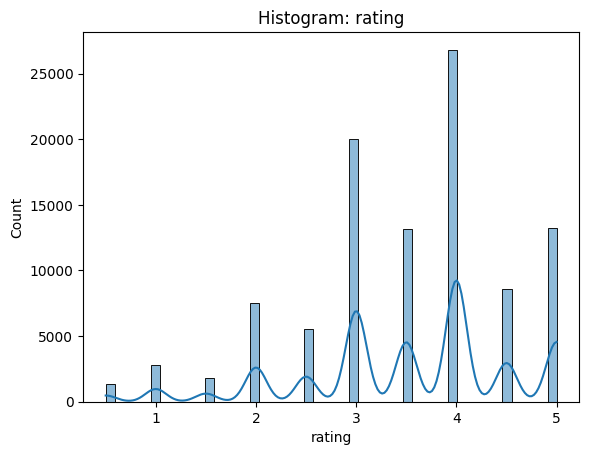

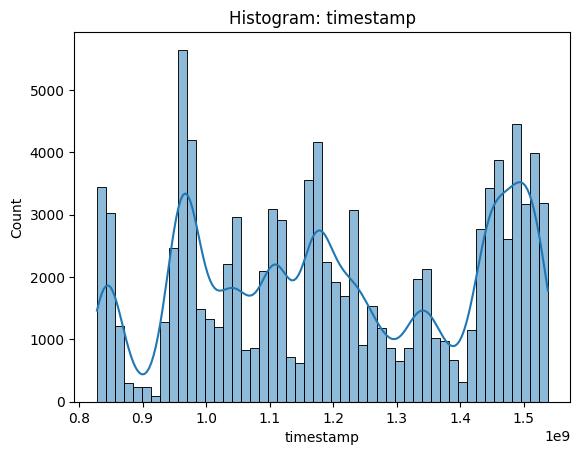

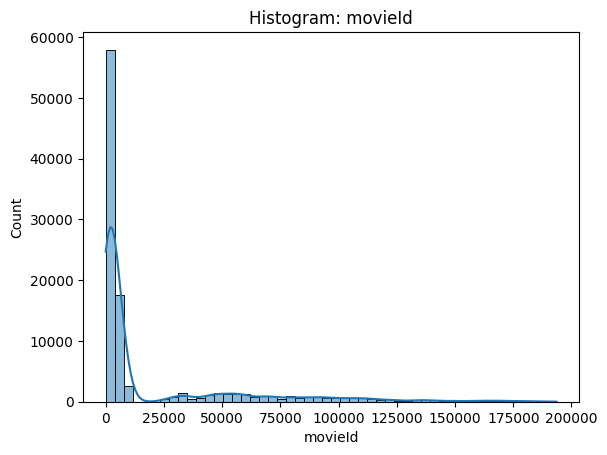

In [12]:
# Plot ratings df
if viewPlots:
    for feature in ratings_to_hist_plot:
        # Create histplots of data untouched
        sns.histplot(data=ratings_df, x=feature, bins=50, kde=True)
        plt.title(f'Histogram: {feature}')

        plt.show()

In [13]:
#List interested movies features
movies_to_hist_plot = ['movieId']

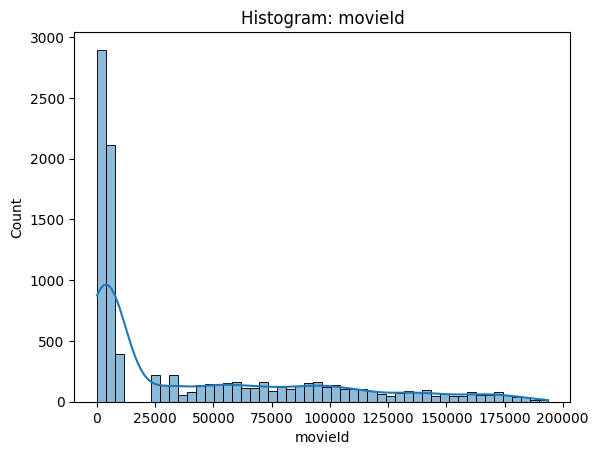

In [14]:
# Plot movie df
if viewPlots:
    for feature in movies_to_hist_plot:
        # Create histplots of data untouched
        sns.histplot(data=movies_df, x=feature, bins=50, kde=True)
        plt.title(f'Histogram: {feature}')

        plt.show()

#### Recommendations:
- MovieId in rating_df is skewed right - this could be a case of popularity, like 'the classics' -> This is an identifier, so leave as is.
- Ratings are typically on the higher side making it slightly skewed left -> We treat this as a discrete numerical, leave as is.
- timestamps just tell us context, nothing needs to change but we can extract labels -> extract dates
- MovieId in movies_df is skewed right as well -> check into what is causing this. For this dataframe, it is suspicious

### Data Discovery
- Discover where timestamp starts and see if it makes sense
- Explore what is happening with movieId from movie_df

In [15]:
# Work with a timedelta object to see what is happening
# Researched and found a universal calendar time "epoch" from gmtime
# Found out we need fromtimestamp() due to thread safety from Y2K legacy issues try converting this sample fromtimestamp()
ratings_timestamp_sample = ratings_df.sample(1)

time_since_rating = datetime.datetime.fromtimestamp(ratings_timestamp_sample['timestamp'].item())

print(f"Time of Rating: {time_since_rating}")
ratings_timestamp_sample

Time of Rating: 2009-01-02 16:25:40


,userId,movieId,rating,timestamp
7458,51,522,3.5,1230931540


In [16]:
# Check the value counts of the skewed movies in rating_df
# Possibly from users watching popular movies
ratings_df['movieId'].value_counts()

movieId
356       329
318       317
296       307
593       279
2571      278
         ... 
160341      1
160527      1
160836      1
163937      1
135534      1
Name: count, Length: 9724, dtype: int64

In [17]:
# Check movies_df for counts in movieId 
movies_df['movieId'].value_counts()

movieId
1         1
2         1
3         1
4         1
5         1
         ..
193581    1
193583    1
193585    1
193587    1
193609    1
Name: count, Length: 9742, dtype: int64

In [18]:
movies_df['title'].value_counts()

title
Saturn 3 (1980)                           2
Confessions of a Dangerous Mind (2002)    2
Emma (1996)                               2
Eros (2004)                               2
War of the Worlds (2005)                  2
                                         ..
SuperFly (2018)                           1
Iron Soldier (2010)                       1
BlacKkKlansman (2018)                     1
The Darkest Minds (2018)                  1
Waiting to Exhale (1995)                  1
Name: count, Length: 9737, dtype: int64

In [19]:
#Check which titles are showing up twice
movies_df[movies_df['title'].duplicated() == True]

,movieId,title,genres
5601,26958,Emma (1996),Romance
6932,64997,War of the Worlds (2005),Action|Sci-Fi
9106,144606,Confessions of a Dangerous Mind (2002),Comedy|Crime|Drama|Romance|Thriller
9135,147002,Eros (2004),Drama|Romance
9468,168358,Saturn 3 (1980),Sci-Fi|Thriller


In [20]:
#Check if any movieIds are duped in movies_df
movies_df[movies_df['movieId'].duplicated() == True]

,movieId,title,genres


In [21]:
# Filter which movieIds skip an iteration of +1 to see how many are skewing the movieId plot, outside of the fact that titles feature shows up multiple times for very few
num_between_movieIds = movies_df['movieId'] - movies_df['movieId'].shift(1)
movies_df[num_between_movieIds > 1]

,movieId,title,genres
32,34,Babe (1995),Children|Drama
33,36,Dead Man Walking (1995),Crime|Drama
34,38,It Takes Two (1995),Children|Comedy
47,52,Mighty Aphrodite (1995),Comedy|Drama|Romance
51,57,Home for the Holidays (1995),Drama
...,...,...,...
9737,193581,Black Butler: Book of the Atlantic (2017),Action|Animation|Comedy|Fantasy
9738,193583,No Game No Life: Zero (2017),Animation|Comedy|Fantasy
9739,193585,Flint (2017),Drama
9740,193587,Bungo Stray Dogs: Dead Apple (2018),Action|Animation


#### Recommendations
- Timestamp on rating is from Epoch time and recorded as seconds since then -> convert these using datetime.fromtimestamp()
- Combine genres on the few duplicated titles to have a one to one mapping of movieId and titles -> keep lower movieId, remove genre dupes
- movieId is a categorical numeric, mostly acting as Nominal Data and is an identifier. So although it jumps around and is skewed right, we leave it be.

## Data Wrangling & Feature Engineering
Apply the following changes:
- Join dupe titles movieId on movie_df, keep lower Id value, and join all genres
- Check movieId removed and update on ratings_df
- Merge both dataframes into merged_df
- Encode genre by separator "|" with Multi-Label Encoder
- Create date features "year", "month", "day"

In [22]:
#check duped titles
movies_df[movies_df['title'].duplicated(keep=False)]

,movieId,title,genres
650,838,Emma (1996),Comedy|Drama|Romance
2141,2851,Saturn 3 (1980),Adventure|Sci-Fi|Thriller
4169,6003,Confessions of a Dangerous Mind (2002),Comedy|Crime|Drama|Thriller
5601,26958,Emma (1996),Romance
5854,32600,Eros (2004),Drama
5931,34048,War of the Worlds (2005),Action|Adventure|Sci-Fi|Thriller
6932,64997,War of the Worlds (2005),Action|Sci-Fi
9106,144606,Confessions of a Dangerous Mind (2002),Comedy|Crime|Drama|Romance|Thriller
9135,147002,Eros (2004),Drama|Romance
9468,168358,Saturn 3 (1980),Sci-Fi|Thriller


In [23]:
# remove dupes using groupby title and taking the min movieId
# join genre by the separator and use set to remove dupes safely
dupes_removed_df = (
    movies_df
    .groupby("title")
    .agg({ 
        "movieId":"min",
        "genres":lambda x: "|".join(sorted(set("|".join(x).split("|"))))
    })
)
dupes_removed_df

,movieId,genres
title,,
'71 (2014),117867,Action|Drama|Thriller|War
'Hellboy': The Seeds of Creation (2004),97757,Action|Adventure|Comedy|Documentary|Fantasy
'Round Midnight (1986),26564,Drama|Musical
'Salem's Lot (2004),27751,Drama|Horror|Mystery|Thriller
'Til There Was You (1997),779,Drama|Romance
...,...,...
eXistenZ (1999),2600,Action|Sci-Fi|Thriller
xXx (2002),5507,Action|Crime|Thriller
xXx: State of the Union (2005),33158,Action|Crime|Thriller


In [24]:
# Merge original movie_df and dupes_removed_df from above to create movieId features _new and _old 
movie_id_mapping = (
    movies_df
    .merge(dupes_removed_df, on="title", suffixes=("_old", "_new"))
    [["movieId_old", "movieId_new"]]
)
movie_id_mapping.iloc[9468]

movieId_old    168358
movieId_new      2851
Name: 9468, dtype: int64

In [25]:
# Merge movie_id_mapping above on old_movieId since it hasn't been changed yet on ratings_df
# Assign the new_movieId to movieId in the ratings_df
# drop temp columns old and new movieId before assigning to ratings_df_clean
ratings_df_clean = (
    ratings_df
    .merge(movie_id_mapping, left_on="movieId", right_on="movieId_old", how="left")
    .assign(movieId=lambda df: df["movieId_new"])
    .drop(columns=["movieId_old", "movieId_new"])
)
ratings_df_clean

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931
...,...,...,...,...
100831,610,166534,4.0,1493848402
100832,610,168248,5.0,1493850091
100833,610,168250,5.0,1494273047
100834,610,168252,5.0,1493846352


In [26]:
# Create merged_df by resetting the index of dupes_removed_df for a clean df
# Inner Merge ratings_df_clean on movie_id
merged_df = (
    dupes_removed_df
    .reset_index()
    .merge(ratings_df_clean, left_on="movieId", right_on="movieId", how="inner")
)
merged_df

,title,movieId,genres,userId,rating,timestamp
0,'71 (2014),117867,Action|Drama|Thriller|War,610,4.0,1493849881
1,'Hellboy': The Seeds of Creation (2004),97757,Action|Adventure|Comedy|Documentary|Fantasy,332,4.0,1352671138
2,'Round Midnight (1986),26564,Drama|Musical,332,3.5,1352671253
3,'Round Midnight (1986),26564,Drama|Musical,377,3.5,1340342092
4,'Salem's Lot (2004),27751,Drama|Horror|Mystery|Thriller,345,5.0,1342827199
...,...,...,...,...,...,...
100831,¡Three Amigos! (1986),2478,Comedy|Western,555,3.0,978823434
100832,¡Three Amigos! (1986),2478,Comedy|Western,561,4.0,1491092281
100833,¡Three Amigos! (1986),2478,Comedy|Western,597,3.0,941641402
100834,¡Three Amigos! (1986),2478,Comedy|Western,599,2.5,1498518515


In [27]:
# Found a Multi Labeling Encoder MultiLabelBinarizer 
mlb = MultiLabelBinarizer()

#Split the genres for transforming
genre_list = merged_df["genres"].str.split("|")

genre_array = mlb.fit_transform(genre_list)

genre_df = pd.DataFrame(
    genre_array, 
    columns=mlb.classes_, 
    index=merged_df.index
)

genre_df

,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0
1,0,1,1,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100831,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1
100832,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1
100833,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1
100834,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [28]:
# Apply fromtimestamp() on the timestamp feature to get our datetime
# since_epoch = (
#     merged_df['timestamp']
#     .apply(lambda x: datetime.datetime.fromtimestamp(x))
# )
since_epoch = pd.to_datetime(merged_df['timestamp'], unit="s")

# Extract year,month,day from Series.dt operation
merged_df["Year"] = since_epoch.dt.year
merged_df["Month"],  = since_epoch.dt.month, 
merged_df["Day"] = since_epoch.dt.day

merged_df


,title,movieId,genres,userId,rating,timestamp,Year,Month,Day
0,'71 (2014),117867,Action|Drama|Thriller|War,610,4.0,1493849881,2017,5,3
1,'Hellboy': The Seeds of Creation (2004),97757,Action|Adventure|Comedy|Documentary|Fantasy,332,4.0,1352671138,2012,11,11
2,'Round Midnight (1986),26564,Drama|Musical,332,3.5,1352671253,2012,11,11
3,'Round Midnight (1986),26564,Drama|Musical,377,3.5,1340342092,2012,6,22
4,'Salem's Lot (2004),27751,Drama|Horror|Mystery|Thriller,345,5.0,1342827199,2012,7,20
...,...,...,...,...,...,...,...,...,...
100831,¡Three Amigos! (1986),2478,Comedy|Western,555,3.0,978823434,2001,1,6
100832,¡Three Amigos! (1986),2478,Comedy|Western,561,4.0,1491092281,2017,4,2
100833,¡Three Amigos! (1986),2478,Comedy|Western,597,3.0,941641402,1999,11,3
100834,¡Three Amigos! (1986),2478,Comedy|Western,599,2.5,1498518515,2017,6,26


<h4 style="color: red; font-size: 30px">Andrew: merged_df creation</h4>

In [29]:
# Merge our multi-label encoded genres_df and extracted dates back into merge_df
merged_df = pd.concat(
    [
        merged_df.reset_index(drop=True), 
        genre_df.reset_index(drop=True)
    ],
    axis=1
)
merged_df

,title,movieId,genres,userId,rating,timestamp,Year,Month,Day,(no genres listed),...,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,'71 (2014),117867,Action|Drama|Thriller|War,610,4.0,1493849881,2017,5,3,0,...,0,0,0,0,0,0,0,1,1,0
1,'Hellboy': The Seeds of Creation (2004),97757,Action|Adventure|Comedy|Documentary|Fantasy,332,4.0,1352671138,2012,11,11,0,...,0,0,0,0,0,0,0,0,0,0
2,'Round Midnight (1986),26564,Drama|Musical,332,3.5,1352671253,2012,11,11,0,...,0,0,0,1,0,0,0,0,0,0
3,'Round Midnight (1986),26564,Drama|Musical,377,3.5,1340342092,2012,6,22,0,...,0,0,0,1,0,0,0,0,0,0
4,'Salem's Lot (2004),27751,Drama|Horror|Mystery|Thriller,345,5.0,1342827199,2012,7,20,0,...,0,1,0,0,1,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100831,¡Three Amigos! (1986),2478,Comedy|Western,555,3.0,978823434,2001,1,6,0,...,0,0,0,0,0,0,0,0,0,1
100832,¡Three Amigos! (1986),2478,Comedy|Western,561,4.0,1491092281,2017,4,2,0,...,0,0,0,0,0,0,0,0,0,1
100833,¡Three Amigos! (1986),2478,Comedy|Western,597,3.0,941641402,1999,11,3,0,...,0,0,0,0,0,0,0,0,0,1
100834,¡Three Amigos! (1986),2478,Comedy|Western,599,2.5,1498518515,2017,6,26,0,...,0,0,0,0,0,0,0,0,0,1


#### Changes Summary
- Duplicate movie titles were merged and handled cleanly.
- Each title took the lowest movieId and was retained while the genres were unioned.
- Ratings were mapped to their respective movieIds for reference.
- Genres were split and multi-label encoded for representation. 
- Timestamp was processed to datetime and Year,Month,Day were extracted 

## User-Item Matrix Creation
Following Goals to accomplish:
- Create a dataframe ui_matrix_df using the following
    - index = userId
    - columns = title
    - values = rating
- Fill missing rating values (look into cosine and pearson similarities)
- Create a predictive rating user-item matrix for optimized results
- Create and test a user based collaboration filter
- Create and test an item based collaboration filter

In [ ]:
#Create a user-item matrix with pivot table
user_item_matrix = merged_df.pivot_table(
    index="userId",
    columns="movieId",
    values="rating"
)

user_item_matrix

movieId,1,2,3,4,5,6,7,8,9,10,...,193565,193567,193571,193573,193579,193581,193583,193585,193587,193609
userId,,,,,,,,,,,,,,,,,,,,,
1,4.0,NaN,4.0,NaN,NaN,4.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
606,2.5,NaN,NaN,NaN,NaN,NaN,2.5,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
607,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
608,2.5,2.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### User Based Collaboration
Proceed to do the following:
- Create User rating centered Matrix with user based ratings
- Create user-user matrices for cosine and pearson
- Create function to take in movieId and n number of similar users

In [238]:
#Compute user means
user_means = user_item_matrix.mean(axis=1)
print(user_means)

#Create mean centered ratings
item_user_centered = user_item_matrix.T.sub(user_means, axis=0)

item_user_centered

userId
1      4.366379
2      3.948276
3      2.435897
4      3.555556
5      3.636364
         ...   
606    3.657399
607    3.786096
608    3.134176
609    3.270270
610    3.688556
Length: 610, dtype: float64


userId,1,2,3,4,5,6,7,8,9,10,...,601,602,603,604,605,606,607,608,609,610
1,-0.366379,NaN,NaN,NaN,-0.366379,NaN,0.133621,NaN,NaN,NaN,...,-0.366379,NaN,-0.366379,-1.366379,-0.366379,-1.866379,-0.366379,-1.866379,-1.366379,0.633621
2,NaN,NaN,NaN,NaN,NaN,0.051724,NaN,0.051724,NaN,NaN,...,NaN,0.051724,NaN,1.051724,-0.448276,NaN,NaN,-1.948276,NaN,NaN
3,1.564103,NaN,NaN,NaN,NaN,2.564103,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.435897,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,-0.555556,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,1.363636,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,-0.636364,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
193581,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
193583,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
193585,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
193587,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [231]:
#Fill NaNs with 0 (neutral after centering) for cosine similarity
user_user_matrix = item_user_centered.fillna(0)

# Compute values with cosine similarity
user_cosine_similarity = cosine_similarity(user_user_matrix.T)

#Convert back into df
user_cosine_similarity_df = pd.DataFrame(
    user_cosine_similarity,
    columns=user_user_matrix.columns,
    index=user_user_matrix.columns
)
user_cosine_similarity_df

user_cosine_similarity_df.head(20)

userId,1,2,3,4,5,6,7,8,9,10,...,601,602,603,604,605,606,607,608,609,610
userId,,,,,,,,,,,,,,,,,,,,,
1,1.000000,0.294246,-0.091270,0.135781,0.127033,0.118858,0.229723,0.183644,-0.014950,0.158719,...,0.380612,0.158798,0.055252,-0.016912,0.060970,0.048357,0.087573,0.011195,0.013817,0.274638
2,0.294246,1.000000,0.000000,0.000000,0.052727,0.088681,0.000000,-0.087909,0.000000,0.000000,...,-0.210073,-0.048080,0.000000,0.000000,0.000000,0.014890,-0.098234,0.046802,-0.035657,0.049600
3,-0.091270,0.000000,1.000000,0.000000,-0.091853,0.087916,0.000000,-0.093061,0.000000,0.000000,...,-0.222383,-0.050898,0.052783,0.000000,0.000000,-0.076608,-0.103991,0.040672,0.000000,0.060836
4,0.135781,0.000000,0.000000,1.000000,-0.022095,0.095973,0.121603,0.048940,0.000000,0.302318,...,-0.032946,0.197491,0.055622,0.044544,0.191496,0.033188,0.105054,0.026078,0.038865,0.010350
5,0.127033,0.052727,-0.091853,-0.022095,1.000000,0.065992,0.085877,0.037256,0.000000,-0.069395,...,0.133462,0.076641,0.120043,0.062278,-0.076019,0.166615,0.036547,0.051979,0.152371,-0.000726
6,0.118858,0.088681,0.087916,0.095973,0.065992,1.000000,-0.014459,-0.059646,0.070893,0.139748,...,-0.052717,0.087820,0.057854,0.055562,0.054279,0.039687,0.158237,0.124046,0.076615,0.074610
7,0.229723,0.000000,0.000000,0.121603,0.085877,-0.014459,1.000000,0.220046,0.000000,-0.044600,...,0.278807,0.141427,0.097326,0.100621,0.239601,0.141994,0.171305,0.056035,0.044542,0.141377
8,0.183644,-0.087909,-0.093061,0.048940,0.037256,-0.059646,0.220046,1.000000,0.000000,0.066651,...,0.411684,0.220081,0.050688,0.131997,0.059222,0.113176,0.071717,0.192808,0.029952,0.117792
9,-0.014950,0.000000,0.000000,0.000000,0.000000,0.070893,0.000000,0.000000,1.000000,0.000000,...,0.000000,0.100682,-0.012759,0.031747,0.000000,0.056313,0.000000,-0.016776,0.000000,0.000000


In [232]:
# Compute values with pearson similarity using the already centered matrix
user_pearson_similarity_df = item_user_centered.corr(method="pearson")

user_pearson_similarity_df.head(20)

userId,1,2,3,4,5,6,7,8,9,10,...,601,602,603,604,605,606,607,608,609,610
userId,,,,,,,,,,,,,,,,,,,,,
1,1.000000,NaN,NaN,0.746187,0.357905,0.147336,0.575922,0.627912,NaN,1.000000,...,0.905129,0.275968,0.280287,-0.146083,0.593914,0.173622,0.306433,0.329073,0.312397,0.485380
2,NaN,1.0,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,NaN,NaN
3,NaN,NaN,1.0,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.000000,NaN,NaN
4,0.746187,NaN,NaN,1.000000,-0.134235,0.387661,0.907931,0.385953,NaN,1.000000,...,NaN,0.508987,0.168969,0.399315,0.961163,0.333041,0.455140,0.148724,1.000000,0.151141
5,0.357905,NaN,NaN,-0.134235,1.000000,0.184397,0.332343,0.144253,NaN,-0.250319,...,0.556897,0.250583,0.369890,0.178146,-0.105029,0.431197,0.159949,0.160396,0.554933,0.034109
6,0.147336,1.0,1.0,0.387661,0.184397,1.000000,-0.083730,-0.150753,1.0,0.970605,...,-0.559164,0.195583,0.185455,0.140072,0.423990,0.120735,0.434642,0.288158,0.399115,0.294150
7,0.575922,NaN,NaN,0.907931,0.332343,-0.083730,1.000000,0.511484,NaN,-1.000000,...,1.000000,0.421296,0.715426,0.729782,0.500858,0.421657,0.485797,0.431469,0.604728,0.073258
8,0.627912,NaN,NaN,0.385953,0.144253,-0.150753,0.511484,1.000000,NaN,-0.998253,...,1.000000,0.327891,0.205974,0.476608,0.133603,0.394429,0.068336,0.523785,0.111399,0.287901
9,NaN,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,1.0,NaN,...,NaN,NaN,-1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<h4 style="color: red; font-size: 30px">Andrew: User-Based Function</h4>

In [437]:
#Create a function to predict ratings of selected movieId
def predicted_rating(userId: int, movieId: int):

    """
    This is a predicting rating of movies for a user function based on 50 similar users.

    Args:
        param1 (int): The first parameter is the userId you want to predict for
        param2 (int): The selected movieId you want to predict for based on 50 similar users

    Returns:
        Series: predicted rating for the selected movieId

    Raises:
        IndexError: If an invalid value for movieId or userId is provided 
    """


    #Get the mapping of selected movieId to title
    selected_movie_rows = (
        merged_df
        .loc[merged_df["movieId"] == movieId, ["title","userId","rating"]]
    )

    #get the 50 similar users to the selected user
    #rename to similarity and reset as a dataframe
    top_users = (
        user_cosine_similarity_df
        .loc[userId]
        .drop(userId)
        .sort_values(ascending=False)
        .head(50)
        .rename("similarity")
        .reset_index()
    )

    #Get mean of selected movie based on other users ratings
    predicted_rating_avg = (
        selected_movie_rows
        .merge(top_users, on="userId", how="inner")
        .groupby("title")
        .agg(mean_rating=("rating", "mean"))
    )
    
    # Rank the matrix with Predictive ratings from other movie item ratings
    print(f"Predicted Rating for user -> {userId}:")
    return predicted_rating_avg

#predict movie rating for userId 1
predicted_rating(1, 32)

Predicted Rating for user -> 1:


,mean_rating
title,
Twelve Monkeys (a.k.a. 12 Monkeys) (1995),3.916667


Key Takeaways
- Creating user-user matrices we understand pearson can return a NaN due to having zero variance, maybe the movieId has no ratings, this is ok
- Creating the cosine one, we used .sub to mean center this for finding a magnitude for rated movieIds and filled 0 for cosine zero vector
- Experimented with fillna(means) it gave all 1's or close to 1's because of almost zero variance between all users, did NOT go with this strategy
- predicted_rating function reflects users ratings and how they rated other movies similarly to other users

### Item Based Collaboration
Proceed to do the following:
- Create Item-Item Matrix filling with item based ratings
- Create function to take in movieId and n number of movies similar

In [ ]:
#Compute item means
movie_means = user_item_matrix.mean(axis=0)
print(movie_means)

#Create and Fill items with their averages for item_item_matrix
#This is bad, everything turns into all movies being 1
# item_item_matrix = user_item_matrix.fillna(movie_means)

#Mean centered ratings
user_item_centered = user_item_matrix.sub(movie_means, axis=1)

user_item_centered

movieId
1         3.920930
2         3.431818
3         3.259615
4         2.357143
5         3.071429
            ...   
193581    4.000000
193583    3.500000
193585    3.500000
193587    3.500000
193609    4.000000
Length: 9719, dtype: float64


movieId,1,2,3,4,5,6,7,8,9,10,...,193565,193567,193571,193573,193579,193581,193583,193585,193587,193609
userId,,,,,,,,,,,,,,,,,,,,,
1,0.07907,NaN,0.740385,NaN,NaN,0.053922,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,0.07907,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
606,-1.42093,NaN,NaN,NaN,NaN,NaN,-0.685185,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
607,0.07907,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
608,-1.42093,-1.431818,-1.259615,NaN,NaN,NaN,NaN,NaN,NaN,0.503788,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [166]:
#Fill NaNs with 0 (neutral after centering) for cosine similarity
item_item_matrix = user_item_centered.fillna(0)

# Compute values with cosine similarity
item_cosine_similarity = cosine_similarity(item_item_matrix.T)

#Convert back into df
item_cosine_similarity_df = pd.DataFrame(
    item_cosine_similarity,
    columns=item_item_matrix.columns,
    index=item_item_matrix.columns
)
item_cosine_similarity_df.head(20)

movieId,1,2,3,4,5,6,7,8,9,10,...,193565,193567,193571,193573,193579,193581,193583,193585,193587,193609
movieId,,,,,,,,,,,,,,,,,,,,,
1,1.000000,0.139649,0.113850,0.032658,0.076230,0.037291,0.064268,0.085986,0.041389,-0.008184,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.139649,1.000000,0.187303,-0.016897,0.154411,0.067458,0.067552,0.031078,0.046682,0.007021,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.113850,0.187303,1.000000,0.071153,0.220868,0.185618,0.195055,0.188311,0.160743,-0.010144,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.032658,-0.016897,0.071153,1.000000,0.128339,0.004044,0.022439,0.012922,0.000000,0.076458,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.076230,0.154411,0.220868,0.128339,1.000000,0.080362,0.217156,0.224129,0.070375,0.047833,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.037291,0.067458,0.185618,0.004044,0.080362,1.000000,-0.007616,-0.046806,-0.057809,0.161337,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.064268,0.067552,0.195055,0.022439,0.217156,-0.007616,1.000000,0.190413,0.017319,0.029021,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.085986,0.031078,0.188311,0.012922,0.224129,-0.046806,0.190413,1.000000,0.000000,0.051416,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.041389,0.046682,0.160743,0.000000,0.070375,-0.057809,0.017319,0.000000,1.000000,-0.000191,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [168]:
# Compute values with pearson similarity using the already centered matrix
item_pearson_similarity_df = user_item_centered.corr(method="pearson")

item_pearson_similarity_df.head(20)

movieId,1,2,3,4,5,6,7,8,9,10,...,193565,193567,193571,193573,193579,193581,193583,193585,193587,193609
movieId,,,,,,,,,,,,,,,,,,,,,
1,1.000000,0.330978,0.487109,1.000000,0.310971,0.106465,0.208402,0.968246,0.095913,-2.140882e-02,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.330978,1.000000,0.419564,NaN,0.562791,0.163510,0.430261,0.415227,0.277350,1.662613e-02,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.487109,0.419564,1.000000,NaN,0.602266,0.345069,0.554088,0.333333,0.458591,-5.027586e-02,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1.000000,NaN,NaN,1.000000,0.654654,NaN,0.203653,NaN,NaN,8.703883e-01,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,0.310971,0.562791,0.602266,0.654654,1.000000,0.291302,0.609119,0.555556,0.319173,2.182633e-01,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,0.106465,0.163510,0.345069,NaN,0.291302,1.000000,-0.123897,-0.801784,-0.172891,4.202222e-01,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,0.208402,0.430261,0.554088,0.203653,0.609119,-0.123897,1.000000,0.816497,0.745356,1.868908e-01,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,0.968246,0.415227,0.333333,NaN,0.555556,-0.801784,0.816497,1.000000,NaN,5.570860e-01,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,0.095913,0.277350,0.458591,NaN,0.319173,-0.172891,0.745356,NaN,1.000000,0.000000e+00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [436]:
## find Jurassic Park (1993) for movieId
merged_df[merged_df["title"] == "Jurassic Park (1993)"]["movieId"]

48856    480
48857    480
48858    480
48859    480
48860    480
        ... 
49089    480
49090    480
49091    480
49092    480
49093    480
Name: movieId, Length: 238, dtype: int64

<h4 style="color: red; font-size: 30px">Andrew: Item-Based Function</h4>

In [435]:
#Create a function to find titles similar to selected movieId
def top_n_movies(movieId: int, n_movies: int):

    """
    This is a top number of similar movies function.

    Args:
        param1 (int): The first parameter is the movieId you want to select
        param2 (int): The number of similar movies the user wants back you selected

    Returns:
        Series: sorted movieIds that are cosine similar to the selected movieId
    
    Raises:
        IndexError: If an invalid value for movieId is provided
    """


    #Get the mapping of selected movieId to title
    mapped_movie = (
        merged_df
        .loc[merged_df["movieId"] == movieId, "title"]
        .iloc[0]
    )

    #get the number of movies user wants and sort it
    top_movies = (
        item_cosine_similarity_df
        .loc[movieId]
        .drop(movieId)
        .sort_values(ascending=False)
        .head(n_movies)
    )

    #show the movie titles for a friendlier output
    mapping_top_movie_titles = (
        merged_df
        .drop_duplicates("movieId")
        .set_index("movieId")["title"]
    )

    #map movieId indices 
    top_movies_return = top_movies.rename(index=mapping_top_movie_titles)

    # Rank the matrix with Predictive ratings from other movie item ratings
    print(f"Movies similar to: {mapped_movie}")
    return top_movies_return

#Target movieIds here and find top N most similar to Jurassic Park (1993)
top_n_movies(480, 10)

Movies similar to: Jurassic Park (1993)


movieId
Fugitive, The (1993)                           0.324717
Lethal Weapon (1987)                           0.318646
Independence Day (a.k.a. ID4) (1996)           0.263629
Mission: Impossible (1996)                     0.258080
Ghostbusters (a.k.a. Ghost Busters) (1984)     0.256527
Mulan (1998)                                   0.255672
Rise of the Planet of the Apes (2011)          0.248134
Bug's Life, A (1998)                           0.240964
Indiana Jones and the Temple of Doom (1984)    0.239826
Die Hard (1988)                                0.239294
Name: 480, dtype: float64

Key Takeaways:
- Creating item-item matrices was a similar issue as user-user
- Creating the matrices required opposite axis mutations to be column-wise
- top_n_movies function reflects users ratings and how they rated other movies similarly to the selected one

## Model Collaborative Filtering
- Test algorithms on user_item_matrix to impute missing rating data
    - SVD
    - NMF
    - KNN
- Perform 5-fold CVs using RMSE
- Determine best model

In [397]:
# numeric_merged_df = (
#     merged_df
#     .select_dtypes(include=["int64", "float64", "int32"])
#     .drop(columns=["timestamp","userId","movieId"])
#     .copy(deep=True)
# )
# numeric_merged_df

In [402]:
user_item_matrix_zero_filled = (
    user_item_matrix
    .fillna(0)
    .copy(deep=True)
)
user_item_matrix_zero_filled

movieId,1,2,3,4,5,6,7,8,9,10,...,193565,193567,193571,193573,193579,193581,193583,193585,193587,193609
userId,,,,,,,,,,,,,,,,,,,,,
1,4.0,0.0,4.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
606,2.5,0.0,0.0,0.0,0.0,0.0,2.5,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
607,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
608,2.5,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### SVD Model (Singular Value Decomposition)
- A linear latent-factor model

In [444]:
# Create SVD model with 50 latent features (Explain user preferences using 50 hidden dimensions)
svd_model = TruncatedSVD(n_components=50, random_state=320)

# Fit model and transform user_item_matrix_zero_filled to user features
movie_features = svd_model.fit_transform(user_item_matrix_zero_filled)

# Reconstruct ratings matrix by multiplying user and item features
print(f"Shape of SVD components: {svd_model.components_.shape}")
predicted_ratings_svd = np.dot(movie_features, svd_model.components_)

# Convert back to DataFrame with original indices
predicted_ratings_svd_df = pd.DataFrame(
    predicted_ratings_svd,
    index=user_item_matrix.index,
    columns=user_item_matrix.columns
)

print('Predicted ratings matrix shape:', predicted_ratings_svd_df.shape)
predicted_ratings_svd_df.head(20)

Shape of SVD components: (50, 9719)
Predicted ratings matrix shape: (610, 9719)


movieId,1,2,3,4,5,6,7,8,9,10,...,193565,193567,193571,193573,193579,193581,193583,193585,193587,193609
userId,,,,,,,,,,,,,,,,,,,,,
1,1.788724,0.305309,0.799066,0.002254,-0.476955,2.629112,-0.684744,-0.095458,0.084125,1.577145,...,-0.043121,-0.036961,-0.049282,-0.049282,-0.043121,-0.049282,-0.043121,-0.043121,-0.043121,-0.052593
2,0.331848,0.063461,0.018073,0.005896,0.123119,-0.076726,0.047350,0.010635,0.040884,-0.179114,...,0.014770,0.012660,0.016880,0.016880,0.014770,0.016880,0.014770,0.014770,0.014770,0.025460
3,0.028696,0.035201,0.044400,-0.003318,-0.007970,0.125628,-0.007332,-0.001448,0.002054,-0.053966,...,-0.001498,-0.001284,-0.001712,-0.001712,-0.001498,-0.001712,-0.001498,-0.001498,-0.001498,0.000090
4,2.341549,-0.348638,-0.226694,0.086610,0.199880,0.152914,0.487035,0.043321,0.014393,-0.135505,...,-0.001751,-0.001501,-0.002001,-0.002001,-0.001751,-0.002001,-0.001751,-0.001751,-0.001751,-0.023379
5,1.281208,0.785724,0.091956,0.126934,0.318023,0.655884,0.290546,0.139763,-0.091532,0.998128,...,-0.004840,-0.004149,-0.005532,-0.005532,-0.004840,-0.005532,-0.004840,-0.004840,-0.004840,-0.004557
6,4.658690,3.715992,3.149911,0.583686,3.273274,3.727159,3.583298,0.742676,1.275067,3.097823,...,0.018036,0.015460,0.020613,0.020613,0.018036,0.020613,0.018036,0.018036,0.018036,0.006410
7,1.993245,0.861018,-0.018083,-0.048247,0.139740,0.871394,0.068528,-0.064485,0.035171,1.483466,...,-0.011085,-0.009501,-0.012668,-0.012668,-0.011085,-0.012668,-0.011085,-0.011085,-0.011085,-0.009912
8,1.041308,1.138505,0.311772,0.128786,0.265292,0.374845,0.353420,0.099998,-0.158707,1.565855,...,-0.004562,-0.003910,-0.005213,-0.005213,-0.004562,-0.005213,-0.004562,-0.004562,-0.004562,-0.000951
9,0.193024,0.224562,0.058188,0.028283,0.012545,-0.208273,-0.007537,-0.007590,-0.027351,0.062674,...,0.001289,0.001105,0.001473,0.001473,0.001289,0.001473,0.001289,0.001289,0.001289,-0.001755


<h4 style="color: red; font-size: 30px">Andrew: SVD Recommender Function</h4>

In [ ]:
def svd_recommender(userId: int):
    # Select a user from the matrix
    user_id = user_item_matrix.index[userId]

    # Get predicted ratings for this user
    user_predictions_svd = predicted_ratings_svd_df.loc[user_id]

    # Find movies the user hasn't rated (missing values in original matrix)
    unrated_movies_svd = user_item_matrix.loc[user_id][user_item_matrix.loc[user_id].isna()]

    #Test how a user would be recommended movies based on SVD
    svd_recommendations = user_predictions_svd[unrated_movies_svd.index].sort_values(ascending=False)

    #show the movie titles for a friendlier output
    svd_mapping_titles = (
        merged_df
        .drop_duplicates("movieId")
        .set_index("movieId")["title"]
    )

    #map movieId indices 
    svd_recommendations = svd_recommendations.rename(index=svd_mapping_titles)

    print(f'Top 5 recommended movies for user {user_id}:')
    print(svd_recommendations.head())

svd_recommender(319)

Top 5 recommended movies for user 320:
movieId
WALL·E (2008)                                                0.354992
Dark Knight, The (2008)                                      0.313147
Lord of the Rings: The Fellowship of the Ring, The (2001)    0.295264
Matrix, The (1999)                                           0.289539
Inception (2010)                                             0.279817
Name: 320, dtype: float64


### NMF Model (Non-Negative Matrix Factorization)

In [457]:
#Create the NMF model
nmf_model = NMF(n_components=50, random_state=320, max_iter=500)

#fit_tranform for user factors
nmf_x = nmf_model.fit_transform(user_item_matrix_zero_filled)

#get item factors from components_
nmf_comp = nmf_model.components_

print(f"Shape of Users: {nmf_x.shape}")
print(f"Shape of Items: {nmf_comp.shape}")

#Dot product reconstruction for Predicted ratings 
predicted_ratings_nmf = np.dot(nmf_x, nmf_comp)

# Convert back to DataFrame with original indices
predicted_ratings_nmf_df = pd.DataFrame(
    predicted_ratings_nmf,
    index=user_item_matrix.index,
    columns=user_item_matrix.columns
)

print('Predicted ratings matrix shape:', predicted_ratings_svd_df.shape)
predicted_ratings_svd_df.head(20)

Shape of Users: (610, 50)
Shape of Items: (50, 9719)
Predicted ratings matrix shape: (610, 9719)


movieId,1,2,3,4,5,6,7,8,9,10,...,193565,193567,193571,193573,193579,193581,193583,193585,193587,193609
userId,,,,,,,,,,,,,,,,,,,,,
1,1.788724,0.305309,0.799066,0.002254,-0.476955,2.629112,-0.684744,-0.095458,0.084125,1.577145,...,-0.043121,-0.036961,-0.049282,-0.049282,-0.043121,-0.049282,-0.043121,-0.043121,-0.043121,-0.052593
2,0.331848,0.063461,0.018073,0.005896,0.123119,-0.076726,0.047350,0.010635,0.040884,-0.179114,...,0.014770,0.012660,0.016880,0.016880,0.014770,0.016880,0.014770,0.014770,0.014770,0.025460
3,0.028696,0.035201,0.044400,-0.003318,-0.007970,0.125628,-0.007332,-0.001448,0.002054,-0.053966,...,-0.001498,-0.001284,-0.001712,-0.001712,-0.001498,-0.001712,-0.001498,-0.001498,-0.001498,0.000090
4,2.341549,-0.348638,-0.226694,0.086610,0.199880,0.152914,0.487035,0.043321,0.014393,-0.135505,...,-0.001751,-0.001501,-0.002001,-0.002001,-0.001751,-0.002001,-0.001751,-0.001751,-0.001751,-0.023379
5,1.281208,0.785724,0.091956,0.126934,0.318023,0.655884,0.290546,0.139763,-0.091532,0.998128,...,-0.004840,-0.004149,-0.005532,-0.005532,-0.004840,-0.005532,-0.004840,-0.004840,-0.004840,-0.004557
6,4.658690,3.715992,3.149911,0.583686,3.273274,3.727159,3.583298,0.742676,1.275067,3.097823,...,0.018036,0.015460,0.020613,0.020613,0.018036,0.020613,0.018036,0.018036,0.018036,0.006410
7,1.993245,0.861018,-0.018083,-0.048247,0.139740,0.871394,0.068528,-0.064485,0.035171,1.483466,...,-0.011085,-0.009501,-0.012668,-0.012668,-0.011085,-0.012668,-0.011085,-0.011085,-0.011085,-0.009912
8,1.041308,1.138505,0.311772,0.128786,0.265292,0.374845,0.353420,0.099998,-0.158707,1.565855,...,-0.004562,-0.003910,-0.005213,-0.005213,-0.004562,-0.005213,-0.004562,-0.004562,-0.004562,-0.000951
9,0.193024,0.224562,0.058188,0.028283,0.012545,-0.208273,-0.007537,-0.007590,-0.027351,0.062674,...,0.001289,0.001105,0.001473,0.001473,0.001289,0.001473,0.001289,0.001289,0.001289,-0.001755


<h4 style="color: red; font-size: 30px">Andrew: NMF Recommender Function</h4>

In [458]:
def nmf_recommender(userId: int):
    # Select a user from the matrix
    user_id = user_item_matrix.index[userId]

    # Get predicted ratings for this user
    user_predictions = predicted_ratings_nmf_df.loc[user_id]

    # Find movies the user hasn't rated (missing values in original matrix)
    unrated_movies = user_item_matrix.loc[user_id][user_item_matrix.loc[user_id].isna()]

    #Test how a user would be recommended movies based on SVD
    recommendations = user_predictions[unrated_movies.index].sort_values(ascending=False)

    #show the movie titles for a friendlier output
    mapping_titles = (
        merged_df
        .drop_duplicates("movieId")
        .set_index("movieId")["title"]
    )

    #map movieId indices 
    recommendations = recommendations.rename(index=mapping_titles)

    print(f'Top 5 recommended movies for user {user_id}:')
    print(recommendations.head())

nmf_recommender(319)

Top 5 recommended movies for user 320:
movieId
Lord of the Rings: The Return of the King, The (2003)        0.340559
Lord of the Rings: The Fellowship of the Ring, The (2001)    0.339616
Lord of the Rings: The Two Towers, The (2002)                0.315695
Dark Knight, The (2008)                                      0.286696
WALL·E (2008)                                                0.275397
Name: 320, dtype: float64


### KNN Model (K-Nearest Neighbors)

In [467]:
#Create the KNN model
knn_model = NearestNeighbors(n_neighbors=50, metric="cosine")

#fit on transpose for item based KNN, the fit expects "samples x features", most similar items(easier to recommend movies per user)
knn_item_matrix = user_item_matrix_zero_filled.T
knn_model.fit(knn_item_matrix)

,n_neighbors,50
,radius,1.0
,algorithm,'auto'
,leaf_size,30
,metric,'cosine'
,p,2
,metric_params,None
,n_jobs,None


In [472]:
def predict_knn_rating(user_id:int, movie_id:int, k:int=20):
    #get the movieId and turn the series back into a 2D array for kneighbors()
    movie_vector = knn_item_matrix.loc[movie_id].values.reshape(1, -1)

    #use the features and find the nearest neighbors with similar tastes
    # increase n_neighbors by 1 to make up for the same movie selected that comes back
    distances, indices = knn_model.kneighbors(movie_vector, n_neighbors=k+1)

    #use the indices to find the neighbors minus the first one being the same as parameter
    neighbors = knn_item_matrix.index[indices.flatten()[1:]]

    #subtract 1 from distance for cosine similarity 
    similarities = 1 - distances.flatten()[1:]

    #Get user's ratings for their neighbors
    ratings = user_item_matrix.loc[user_id, neighbors]

    #Mask for user's who never rated the movie selected, if none found we send NaN
    mask = ratings.notna()
    if mask.sum() == 0:
        return np.nan

    #Use the similarity weighted average formula to our masked data results
    return np.dot(similarities[mask], ratings[mask]) / similarities[mask].sum()

predict_knn_rating(319, 480)

np.float64(4.604420785437398)

<h4 style="color: red; font-size: 30px">Andrew: KNN Recommender Function</h4>

In [ ]:
def knn_recommender(user_id:int, n:int=10, k:int=20):
    unrated_movies = user_item_matrix.loc[user_id].isna()
    unrated_movie_ids = user_item_matrix.columns[unrated_movies]

    predictions = {}

    for movie_id in unrated_movie_ids:
        #Run our function above to get predicted knn ratings based on k neighbors 
        pred = predict_knn_rating(user_id, movie_id, k)
        if not np.isnan(pred):
            predictions[movie_id] = pred

    return (
        pd.Series(predictions)
        .sort_values(ascending=False)
        .head(n)
    )

knn_recommender(user_id=319)

69122     5.0
551       5.0
5618      5.0
2617      5.0
124851    5.0
85414     5.0
260       5.0
337       5.0
541       5.0
81591     5.0
dtype: float64

### RMSE Metric Testing
- Test our models against RMSE to see how they perform